### Imports

In [1]:
#import boto3
import pandas as pd
import os
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import importlib
import utils
import sys
from datetime import datetime
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\keith\\OneDrive\\Desktop\\Data Science w Cloiud\\Meta Ad Analysis Project\\Ad-Data-Analysis-Lingerie\\.venv\\lib\\site-packages\\utils\\__init__.py'>

### Read csv and save in a pandas library Data Frame

In [2]:
# Load the data into a pandas DataFrame
df = pd.read_csv('data/raw/campain_add_data_taskher.csv')

### Pre-processing
1. We begin by examining the structure of our data.

2. We can see that there are NaN values - The NaN values in Result, Result Type and Cost Per Result likely denotes that no Results were recieved, this will be encoded and communicated differently.

3. Column Names to made lowercase and addition of underscores for ease of handling casing, All string feature values are to be made lowercase with deletion of any white space.

4. How many unique Ad Set Names Exist?

5. Campaign name, Ad set name and Ad name can be parsed to produce additional features, These 3 columns can then be dropped later on as the information they represent will be available within the dataset

In [3]:
# Display the first few rows
df.head()

,Campaign name,Ad set name,Ad name,Age,Gender,Delivery status,Delivery level,Reach,Impressions,Frequency,Attribution setting,Result Type,Results,Amount spent (GBP),Cost per result,Starts,Ends,Reporting starts,Reporting ends
0,LOC|01.10|MID|PRS|QUOTE|ALL- Islington&Southwa...,ISLINGTON|ALL|18-55|COLD|Broad|IG|ALL,ISL-ELEC|IFD-STOR-RL|IMG|purple_cta_bulb,25-34,female,inactive,ad,46370,83136,1.792883,7-day click or 1-day view,quoteReceived,39.0,618.69,15.86,2024-05-09,2024-12-22,2024-04-01,2025-04-08
1,LOC|01.10|MID|PRS|QUOTE|ALL- Islington&Southwa...,SOUTHWARK|ALL|18-55|COLD|Broad|IG|ALL,STW-ELEC|IFD-STOR-RL|IMG|purple_cta_bulb,25-34,female,not_delivering,ad,48362,87271,1.804537,7-day click or 1-day view,quoteReceived,38.0,548.71,14.44,2024-05-09,2024-10-31,2024-04-01,2025-04-08
2,LOC|01.10|MID|PRS|QUOTE|ALL- Islington&Southwa...,ISLINGTON|ALL|18-55|COLD|Broad|IG|ALL,ISL-ELEC|IFD-STOR-RL|IMG|purple_cta_bulb,35-44,female,inactive,ad,24961,42207,1.690918,7-day click or 1-day view,quoteReceived,18.0,402.15,22.34,2024-05-09,2024-12-22,2024-04-01,2025-04-08
3,LDN|01.10|UPP|BAW|FAN|ALL - IGFollower,LDN|ALL|18-55|LAL|Followers&WebsiteVisitors|IG...,GEN|IFD-STOR-RL|VID|tradeplaces,25-34,female,not_delivering,ad,38045,74399,1.955553,7-day click or 1-day view,actions:visit_instagram_profile,3599.0,398.62,0.11,2024-05-08,2024-12-30,2024-04-01,2025-04-08
4,LDN|02.04|MID|RTG|QUOTE|ALL - WARM,LDN|ALL|18-45|RTG|IGFollowers&Engagers|IG|ALL,GEN|IFD-STOR-RL|VID|TradePlaces,25-34,female,inactive,ad,9102,31349,3.444188,7-day click or 1-day view,quoteReceived,36.0,347.45,9.65,2024-05-09,2025-04-30,2024-04-01,2025-04-08


Campaign name =
LOCATION | DATE | FUNNEL STAGE | GOAL | TACTIC | DESCRIPTION

Ad set name =
LOCATION | GENDER | AGE | AUDIENCE SEGMENT | AUDIENCE DETAIL | PLATFORM | PLACEMENT

Ad name =
SERVICE | AD FORMAT | ASSET TYPE | AD DESCRIPTION

In [4]:
from src.preprocessor.core import preprocess_campaign_data
output_path = "local_run/output"

# Preprocess the data
# Steps include:
df = preprocess_campaign_data(df, output_path)


c:\Users\keith\OneDrive\Desktop\Data Science w Cloiud\Meta Ad Analysis Project\Ad-Data-Analysis-Lingerie\src\preprocessor\steps\drop_and_fix_rows.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[string_cols] = df[string_cols].applymap(clean_strings)


In [5]:
df.head()

,campaign_name,ad_set_name,ad_name,age,gender,delivery_status,delivery_level,reach,impressions,frequency,...,adset_gender,adset_age,adset_audiencesegment,adset_audiencedetail,adset_platform,adset_placement,ad_service,ad_format,ad_assettype,ad_description
0,loc|01.10|mid|prs|quote|all-islington&southwar...,islington|all|18-55|cold|broad|ig|all,isl-elec|ifd-stor-rl|img|purple_cta_bulb,25-34,female,inactive,ad,46370,83136,1.792883,...,all,18-55,cold,broad,ig,all,isl-elec,ifd-stor-rl,img,purple_cta_bulb
1,loc|01.10|mid|prs|quote|all-islington&southwar...,southwark|all|18-55|cold|broad|ig|all,stw-elec|ifd-stor-rl|img|purple_cta_bulb,25-34,female,not_delivering,ad,48362,87271,1.804537,...,all,18-55,cold,broad,ig,all,stw-elec,ifd-stor-rl,img,purple_cta_bulb
2,loc|01.10|mid|prs|quote|all-islington&southwar...,islington|all|18-55|cold|broad|ig|all,isl-elec|ifd-stor-rl|img|purple_cta_bulb,35-44,female,inactive,ad,24961,42207,1.690918,...,all,18-55,cold,broad,ig,all,isl-elec,ifd-stor-rl,img,purple_cta_bulb
3,ldn|01.10|upp|baw|fan|all-igfollower,ldn|all|18-55|lal|followers&websitevisitors|ig...,gen|ifd-stor-rl|vid|tradeplaces,25-34,female,not_delivering,ad,38045,74399,1.955553,...,all,18-55,lal,followers&websitevisitors,ig,all,gen,ifd-stor-rl,vid,tradeplaces
4,ldn|02.04|mid|rtg|quote|all-warm,ldn|all|18-45|rtg|igfollowers&engagers|ig|all,gen|ifd-stor-rl|vid|tradeplaces,25-34,female,inactive,ad,9102,31349,3.444188,...,all,18-45,rtg,igfollowers&engagers,ig,all,gen,ifd-stor-rl,vid,tradeplaces


Checking for null values

In [ ]:
# Check for missing values
 
null_counts = df.isnull().sum()
print(null_counts)


campaign_name            0
ad_set_name              0
ad_name                  0
age                      0
gender                   0
delivery_status          0
delivery_level           0
reach                    0
impressions              0
frequency                0
attribution_setting      0
result_type              0
results                  0
amount_spent_(gbp)       0
starts                   0
ends                     0
reporting_starts         0
reporting_ends           0
campaign_location        0
campaign_date            0
campaign_funnel          0
campaign_goal            0
campaign_tactic          0
campaign_description     0
adset_location           0
adset_gender             0
adset_age                0
adset_audiencesegment    0
adset_audiencedetail     0
adset_platform           0
adset_placement          0
ad_service               0
ad_format                0
ad_assettype             0
ad_description           0
dtype: int64


In [7]:
def count_unique_string_values(df):
    """
    Analyzes string columns in a DataFrame and returns the count of unique values for each.
    
    Args:
        df: pandas DataFrame
        
    Returns:
        A dictionary with column names as keys and unique counts as values
    """
    # Select only string columns
    string_cols = df.select_dtypes(include=['object', 'string']).columns
    
    unique_counts = {}
    
    for col in string_cols:
        # Get unique values and count
        unique_values = df[col].nunique()
        unique_counts[col] = unique_values
        
        # Print value frequencies (optional)
        print(f"\nColumn: {col}")
        print(f"Unique values: {unique_values}")
        print("Value frequencies:")
        print(df[col].value_counts(dropna=False))
    
    return unique_counts

unique_counts = count_unique_string_values(df)


Column: campaign_name
Unique values: 8
Value frequencies:
campaign_name
loc|01.10|mid|prs|quote|all-islington&southwark&hackney    508
ldn|01.10|upp|baw|fan|all-igfollower                       350
ldn|02.04|mid|rtg|quote|all-warm                           338
ldn|01.10|upp|prs|leads|all-form                           143
ldn|01.11|mid|tfk|clicks|all-webv                           99
ldn|15.08|mid|prs|quote|all-cold                            90
ldn|17.12|mid|tfk|clicks|all-crowdf                         18
ldn|09.01|mid|rtg|leads|all-crowdf                          18
Name: count, dtype: int64

Column: ad_set_name
Unique values: 13
Value frequencies:
ad_set_name
ldn|all|18-45|rtg|igfollowers&engagers|ig|all             246
hackney|all|18-55|cold|broad|ig|all                       194
ldn|all|18-55|lal|followers&websitevisitors|ig|all        183
islington|all|18-55|cold|broad|ig|all                     172
ldn|all|18-55|interest|varioustrades|ig|all               144
ldn|all|18-55|col

In [8]:
df.head()

,campaign_name,ad_set_name,ad_name,age,gender,delivery_status,delivery_level,reach,impressions,frequency,...,adset_gender,adset_age,adset_audiencesegment,adset_audiencedetail,adset_platform,adset_placement,ad_service,ad_format,ad_assettype,ad_description
0,loc|01.10|mid|prs|quote|all-islington&southwar...,islington|all|18-55|cold|broad|ig|all,isl-elec|ifd-stor-rl|img|purple_cta_bulb,25-34,female,inactive,ad,46370,83136,1.792883,...,all,18-55,cold,broad,ig,all,isl-elec,ifd-stor-rl,img,purple_cta_bulb
1,loc|01.10|mid|prs|quote|all-islington&southwar...,southwark|all|18-55|cold|broad|ig|all,stw-elec|ifd-stor-rl|img|purple_cta_bulb,25-34,female,not_delivering,ad,48362,87271,1.804537,...,all,18-55,cold,broad,ig,all,stw-elec,ifd-stor-rl,img,purple_cta_bulb
2,loc|01.10|mid|prs|quote|all-islington&southwar...,islington|all|18-55|cold|broad|ig|all,isl-elec|ifd-stor-rl|img|purple_cta_bulb,35-44,female,inactive,ad,24961,42207,1.690918,...,all,18-55,cold,broad,ig,all,isl-elec,ifd-stor-rl,img,purple_cta_bulb
3,ldn|01.10|upp|baw|fan|all-igfollower,ldn|all|18-55|lal|followers&websitevisitors|ig...,gen|ifd-stor-rl|vid|tradeplaces,25-34,female,not_delivering,ad,38045,74399,1.955553,...,all,18-55,lal,followers&websitevisitors,ig,all,gen,ifd-stor-rl,vid,tradeplaces
4,ldn|02.04|mid|rtg|quote|all-warm,ldn|all|18-45|rtg|igfollowers&engagers|ig|all,gen|ifd-stor-rl|vid|tradeplaces,25-34,female,inactive,ad,9102,31349,3.444188,...,all,18-45,rtg,igfollowers&engagers,ig,all,gen,ifd-stor-rl,vid,tradeplaces


In [9]:
unique_counts

{'campaign_name': 8,
 'ad_set_name': 13,
 'ad_name': 54,
 'age': 7,
 'gender': 3,
 'delivery_status': 3,
 'delivery_level': 1,
 'attribution_setting': 1,
 'result_type': 5,
 'starts': 7,
 'ends': 6,
 'reporting_starts': 1,
 'reporting_ends': 1,
 'campaign_location': 2,
 'campaign_date': 6,
 'campaign_funnel': 2,
 'campaign_goal': 4,
 'campaign_tactic': 4,
 'campaign_description': 7,
 'adset_location': 4,
 'adset_gender': 1,
 'adset_age': 3,
 'adset_audiencesegment': 6,
 'adset_audiencedetail': 9,
 'adset_platform': 2,
 'adset_placement': 3,
 'ad_service': 19,
 'ad_format': 1,
 'ad_assettype': 2,
 'ad_description': 36}

In [10]:
def analyze_non_string_features(df):
    # Get non-string features (numeric, boolean, datetime, etc.)
    non_string_cols = df.select_dtypes(exclude=['object', 'string']).columns
    
    print(f"Found {len(non_string_cols)} non-string features:")
    print("="*50)
    
    for col in non_string_cols:
        dtype = df[col].dtype
        unique_count = df[col].nunique()
        sample_values = df[col].dropna().unique()[:5]
        
        print(f"Column: {col}")
        print(f"Type: {dtype}")
        print(f"Unique values: {unique_count}")
        print(f"Sample values: {sample_values}")
        print(f"Missing values: {df[col].isna().sum()} ({df[col].isna().mean():.1%})")
        
        # Basic stats for numeric columns
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f"Min: {df[col].min()}")
            print(f"Max: {df[col].max()}")
            print(f"Mean: {df[col].mean():.2f}")
            print(f"Median: {df[col].median():.2f}")
        
        print("-"*50)

# Usage
analyze_non_string_features(df)

Found 5 non-string features:
Column: reach
Type: int64
Unique values: 496
Sample values: [46370 48362 24961 38045  9102]
Missing values: 0 (0.0%)
Min: 0
Max: 48362
Mean: 681.47
Median: 30.00
--------------------------------------------------
Column: impressions
Type: int64
Unique values: 609
Sample values: [83136 87271 42207 74399 31349]
Missing values: 0 (0.0%)
Min: 0
Max: 87271
Mean: 1262.91
Median: 42.00
--------------------------------------------------
Column: frequency
Type: float64
Unique values: 797
Sample values: [1.79288333 1.80453662 1.69091783 1.95555264 3.44418809]
Missing values: 0 (0.0%)
Min: 0.0
Max: 7.0
Mean: 1.45
Median: 1.20
--------------------------------------------------
Column: results
Type: float64
Unique values: 88
Sample values: [  39.   38.   18. 3599.   36.]
Missing values: 0 (0.0%)
Min: 0.0
Max: 3599.0
Mean: 13.76
Median: 0.00
--------------------------------------------------
Column: amount_spent_(gbp)
Type: float64
Unique values: 614
Sample values: [618.

In [11]:
# Print detailed column information
print("DataFrame Columns Overview:")
print("=" * 50)
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")
    print(f"   Type: {df[col].dtype}")
    print(f"   Unique values: {df[col].nunique()}")
    print(f"   Sample values: {df[col].dropna().unique()[:3]}")
    print("-" * 50)

DataFrame Columns Overview:
1. campaign_name
   Type: object
   Unique values: 8
   Sample values: ['loc|01.10|mid|prs|quote|all-islington&southwark&hackney'
 'ldn|01.10|upp|baw|fan|all-igfollower' 'ldn|02.04|mid|rtg|quote|all-warm']
--------------------------------------------------
2. ad_set_name
   Type: object
   Unique values: 13
   Sample values: ['islington|all|18-55|cold|broad|ig|all'
 'southwark|all|18-55|cold|broad|ig|all'
 'ldn|all|18-55|lal|followers&websitevisitors|ig|all']
--------------------------------------------------
3. ad_name
   Type: object
   Unique values: 54
   Sample values: ['isl-elec|ifd-stor-rl|img|purple_cta_bulb'
 'stw-elec|ifd-stor-rl|img|purple_cta_bulb'
 'gen|ifd-stor-rl|vid|tradeplaces']
--------------------------------------------------
4. age
   Type: object
   Unique values: 7
   Sample values: ['25-34' '35-44' '18-24']
--------------------------------------------------
5. gender
   Type: object
   Unique values: 3
   Sample values: ['female' 'mal

### ANALYSIS FOR POOJ
1. Cheapest Asset Type (Image vs Video) (Adpted to be used by new datasets)

In [ ]:
# cost per quote by asset type

cost_per_quote = (df.groupby('ad_assettype')['amount_spent_(gbp)'].sum() / 
                 df.groupby('ad_assettype')['results'].sum())

print("Cost per quote by asset type:")
print(cost_per_quote.sort_values())

Cost per quote by asset type:
ad_assettype
vid     0.435946
img    11.185380
dtype: float64


2. Cheapest Service Area (Adpted to be used by new datasets)

In [ ]:
# cost per quote by service type

service_cost = (df.groupby('ad_service')['amount_spent_(gbp)'].sum() / 
               df.groupby('ad_service')['results'].sum())

print("\nCost per quote by service:")
print(service_cost.sort_values())


Cost per quote by service:
ad_service
aware         0.139412
gen           0.432923
crowd         0.518434
ugc           1.735695
elec         10.288571
stw-elec     10.943061
hack-plum    11.065833
heat         12.527308
isl-plum     12.699556
stw-gas      12.810000
plum         13.128000
hack-elec    13.670656
isl-gas      18.550000
isl-elec     18.845584
hack-gas     23.770000
isl-boil     27.840000
stw-plum     41.663333
hack-boil          inf
stw-boil           inf
dtype: float64


3. Age and Gender Insights (Adpted to be used by new datasets)

In [14]:
# Age analysis (now uses decoded labels directly)
age_quotes = df.groupby('age')['results'].sum().sort_values(ascending=False)

print("\nQuotes by age group:")
print(age_quotes)

# Gender analysis (uses decoded labels directly)
gender_quotes = df.groupby('gender')['results'].sum()
gender_cost = (df.groupby('gender')['amount_spent_(gbp)'].sum() / 
              df.groupby('gender')['results'].sum())

print("\nQuotes by gender:")
print(gender_quotes)
print("\nCost per quote by gender:")
print(gender_cost)

# Bonus: Add formatted output
def format_analysis(series, title):
    print(f"\n{title}:")
    if series.dtype == 'float64':
        print(series.sort_values().apply(lambda x: f"£{x:.2f}"))
    else:
        print(series.sort_values(ascending=False))

format_analysis(age_quotes, "Quotes by age group (formatted)")
format_analysis(gender_quotes, "Quotes by gender (formatted)")
format_analysis(gender_cost, "Cost per quote by gender (formatted)")


Quotes by age group:
age
25-34      9811.0
18-24      8286.0
35-44      2391.0
45-54       603.0
55-64       269.0
65+         136.0
unknown      19.0
Name: results, dtype: float64

Quotes by gender:
gender
female     13375.0
male        6323.0
unknown     1817.0
Name: results, dtype: float64

Cost per quote by gender:
gender
female     1.075779
male       0.339344
unknown    0.416483
dtype: float64

Quotes by age group (formatted):
age
unknown      £19.00
65+         £136.00
55-64       £269.00
45-54       £603.00
35-44      £2391.00
18-24      £8286.00
25-34      £9811.00
Name: results, dtype: object

Quotes by gender (formatted):
gender
unknown     £1817.00
male        £6323.00
female     £13375.00
Name: results, dtype: object

Cost per quote by gender (formatted):
gender
male       £0.34
unknown    £0.42
female     £1.08
dtype: object


4. Monthly Quote Prediction (£30/day budget)

In [ ]:
# Redirect print output to a file
original_stdout = sys.stdout  # Save original stdout

with open('reports/scripts', 'w') as f:
    sys.stdout = f  # Change stdout to file
    
    # Print report header
    print("="*60)
    print(" AD PERFORMANCE ANALYSIS REPORT".center(60))
    print(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}".center(60))
    print("="*60)
    
    # 1. Age Analysis
    print("\n\n" + " AGE GROUP PERFORMANCE ".center(60, '-'))
    age_quotes = df.groupby('age')['results'].sum().sort_values(ascending=False)
    #age_quotes.index = age_quotes.index.map(age_map)
    print("\nQuotes by age group:")
    print(age_quotes.to_string())
    
    # 2. Gender Analysis
    print("\n\n" + " GENDER PERFORMANCE ".center(60, '-'))
    gender_quotes = df.groupby('gender')['results'].sum()
    gender_cost = (df.groupby('gender')['amount_spent_(gbp)'].sum() / 
                  df.groupby('gender')['results'].sum())
    print("\nQuotes by gender:")
    print(gender_quotes.to_string())
    print("\nCost per quote by gender:")
    print(gender_cost.to_string())
    
    # 3. Service Analysis
    print("\n\n" + " SERVICE PERFORMANCE ".center(60, '-'))
    service_cost = (df.groupby('ad_service')['amount_spent_(gbp)'].sum() / 
                   df.groupby('ad_service')['results'].sum())
    #service_cost.index = service_cost.index.map(reverse_service_map)
    print("\nCost per quote by service:")
    print(service_cost.sort_values().to_string())
    
    # 4. Efficiency Metrics
    #print("\n\n" + " EFFICIENCY METRICS ".center(60, '-'))
    #print(f"\nTotal Amount Spent: £{total_spent:,.2f}")
    #print(f"Total Quotes Received: {total_quotes:,.0f}")
    #print(f"\nCurrent Cost Per Quote (CPQ): £{current_cpq:.2f}")
    #print(f"Quotes per £100 spent: {(total_quotes/total_spent)*100:.1f}")
    #print(f"\nPredicted Monthly Quotes @ £30/day: {predicted_quotes:,.0f}")
    
    print("\n\n" + " END OF REPORT ".center(60, '='))
    
    sys.stdout = original_stdout  # Reset stdout

print("Analysis report saved to 'ad_analysis_report.txt'")

Analysis report saved to 'ad_analysis_report.txt'


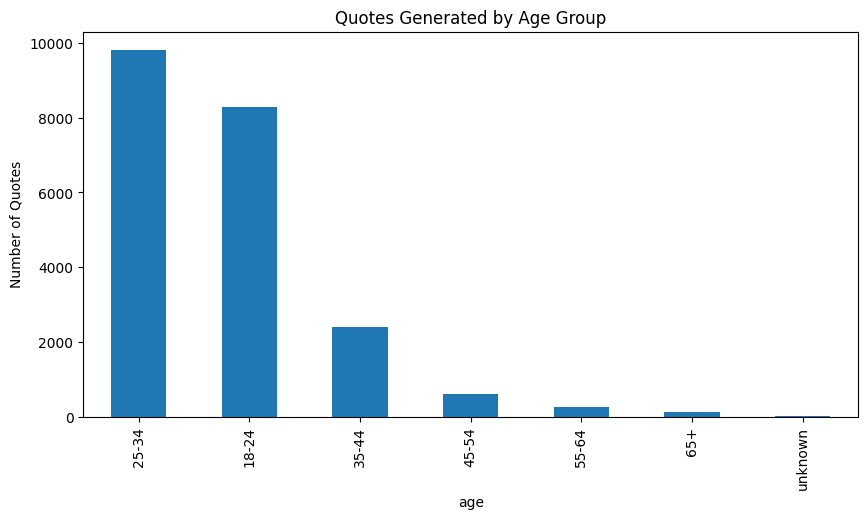

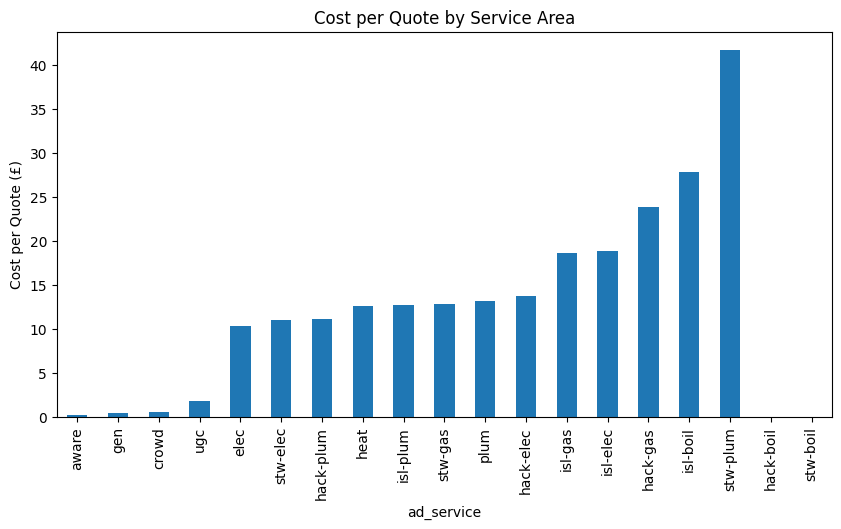

In [15]:
import matplotlib.pyplot as plt

# Visualize age performance
plt.figure(figsize=(10,5))
age_quotes.plot(kind='bar')
plt.title('Quotes Generated by Age Group')
plt.ylabel('Number of Quotes')
plt.show()

# Visualize service efficiency
plt.figure(figsize=(10,5))
service_cost.sort_values().plot(kind='bar')
plt.title('Cost per Quote by Service Area')
plt.ylabel('Cost per Quote (£)')
plt.show()

In [31]:
df['result_type'].unique()

array(['quotereceived', 'actions:visit_instagram_profile', 'metaleads',
       'linkclicks', 'none'], dtype=object)

In [50]:
def cost_per_quote_by_asset_type(df):
    return df.groupby('ad_assettype')['amount_spent_(gbp)'].sum() / df.groupby('ad_assettype')['results'].sum()

def cost_per_quote_by_service(df):
    return df.groupby('ad_service')['amount_spent_(gbp)'].sum() / df.groupby('ad_service')['results'].sum()

def quotes_by_age_group(df):
    return df.groupby('age')['results'].sum()

def quotes_by_gender(df):
    return df.groupby('gender')['results'].sum()

def cost_per_quote_by_gender(df):
    return df.groupby('gender')['amount_spent_(gbp)'].sum() / df.groupby('gender')['results'].sum()

def impression_analytics(df, groupby_cols):
    """
    Summarizes total Impressions, Link Clicks, and Quotes grouped by given columns.
    Ensures 'results' values are only summed based on corresponding 'result_type'.
    """
    df = df.copy()
    df['result_type'] = df['result_type'].str.strip().str.lower()

    # Group total impressions
    impressions = df.groupby(groupby_cols)['impressions'].sum()

    # Extract link clicks from rows where result_type == 'link clicks'
    link_clicks = (
        df[df['result_type'] == 'linkclicks']
        .groupby(groupby_cols)['results']
        .sum()
    )

    # Extract quotes from rows where result_type == 'quoteseceived'
    quotes = (
        df[df['result_type'] == 'quotereceived']
        .groupby(groupby_cols)['results']
        .sum()
    )

    # Extract quotes from rows where result_type == 'quoteseceived'
    meta_leads = (
        df[df['result_type'] == 'metaleads']
        .groupby(groupby_cols)['results']
        .sum()
    )

    # Extract quotes from rows where result_type == 'quoteseceived'
    instagram_visits = (
        df[df['result_type'] == 'actions:visit_instagram_profile']
        .groupby(groupby_cols)['results']
        .sum()
    )

    # Merge all metrics
    summary = pd.concat([impressions, link_clicks, quotes, meta_leads, instagram_visits], axis=1)
    summary.columns = ['Impressions', 'Link Clicks', 'Quotes', 'Meta Leads', 'Instagram Visits']
    summary = summary.fillna(0)

    # Calculate metrics
    summary['CTR (%)'] = (summary['Link Clicks'] / summary['Impressions']) * 100
    summary['Quote Rate (%)'] = (summary['Quotes'] / summary['Impressions']) * 100
    summary['Meta Leads Rate (%)'] = (summary['Meta Leads'] / summary['Impressions']) * 100
    summary['Instagram Visits Rate (%)'] = (summary['Instagram Visits'] / summary['Impressions']) * 100

    return summary.reset_index()

def format_analysis(data, title):
    print(f"\n{'=' * 60}\n{title}\n{'=' * 60}")
    if isinstance(data, pd.Series):
        if data.dtype == 'float64':
            #formatted = data.sort_values().apply(lambda x: f"£{x:.2f}" if pd.notnull(x) and not pd.isinf(x) else "inf")
            formatted = data.sort_values().apply(lambda x: f"£{x:.2f}" if pd.notnull(x) and not np.isinf(x) else "inf")
            print(formatted.to_string())
        else:
            print(data.sort_values(ascending=False).to_string())
    elif isinstance(data, pd.DataFrame):
        print(data.to_string(index=False))
    else:
        print("Unsupported data format.")

def generate_metrics_report(df, pretty_print=True):
    report = {}

    # --- Main Cost Analytics ---
    report['Cost per Quote by Asset Type'] = cost_per_quote_by_asset_type(df)
    report['Cost per Quote by Service'] = cost_per_quote_by_service(df)
    report['Quotes by Age Group'] = quotes_by_age_group(df)
    report['Quotes by Gender'] = quotes_by_gender(df)
    report['Cost per Quote by Gender'] = cost_per_quote_by_gender(df)

    # --- New: Impression Analytics ---
    report['Impression Analysis by Gender'] = impression_analytics(df, ['gender'])
    report['Impression Analysis by Age'] = impression_analytics(df, ['age'])
    report['Impression Analysis by Campaign + Gender'] = impression_analytics(df, ['campaign_name', 'gender'])
    report['Impression Analysis by Ad Set + Age'] = impression_analytics(df, ['ad_set_name', 'age'])

    if pretty_print:
        for title, result in report.items():
            format_analysis(result, title)

    return report


In [41]:
def save_metrics_report(report: dict, folder_path="scripts"):
    """
    Save the metrics report to a timestamped .txt file in the specified folder.
    """
    # Make sure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Timestamped filename
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"campaign_report_{timestamp}.txt"
    filepath = os.path.join(folder_path, filename)

    with open(filepath, "w", encoding="utf-8") as f:
        for title, data in report.items():
            f.write(f"### {title} ###\n")
            if isinstance(data, pd.DataFrame):
                f.write(data.to_string(index=False))
            elif isinstance(data, pd.Series):
                # Format floats if applicable
                if data.dtype == 'float64':
                    formatted = data.sort_values().apply(
                        lambda x: f"£{x:.2f}" if pd.notnull(x) and not np.isinf(x) else "inf"
                    )
                    f.write(formatted.to_string())
                else:
                    f.write(data.to_string())
            else:
                f.write(str(data))
            f.write("\n\n")
    
    print(f"✅ Report saved to {filepath}")


In [51]:
report = generate_metrics_report(df)
save_metrics_report(report)


Cost per Quote by Asset Type
ad_assettype
vid     £0.44
img    £11.19

Cost per Quote by Service
ad_service
aware         £0.14
gen           £0.43
crowd         £0.52
ugc           £1.74
elec         £10.29
stw-elec     £10.94
hack-plum    £11.07
heat         £12.53
isl-plum     £12.70
stw-gas      £12.81
plum         £13.13
hack-elec    £13.67
isl-gas      £18.55
isl-elec     £18.85
hack-gas     £23.77
isl-boil     £27.84
stw-plum     £41.66
hack-boil       inf
stw-boil        inf

Quotes by Age Group
age
unknown      £19.00
65+         £136.00
55-64       £269.00
45-54       £603.00
35-44      £2391.00
18-24      £8286.00
25-34      £9811.00

Quotes by Gender
gender
unknown     £1817.00
male        £6323.00
female     £13375.00

Cost per Quote by Gender
gender
male       £0.34
unknown    £0.42
female     £1.08

Impression Analysis by Gender
 gender  Impressions  Link Clicks  Quotes  Meta Leads  Instagram Visits  CTR (%)  Quote Rate (%)  Meta Leads Rate (%)  Instagram Visits Rate (%

In [ ]:
# Redirect print output to a file
original_stdout = sys.stdout  # Save original stdout

with open('reports/scripts', 'w') as f:
    sys.stdout = f  # Change stdout to file
    
    # Print report header
    print("="*60)
    print(" AD PERFORMANCE ANALYSIS REPORT".center(60))
    print(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}".center(60))
    print("="*60)
    
    # 1. Age Analysis
    print("\n\n" + " AGE GROUP PERFORMANCE ".center(60, '-'))
    age_quotes = df.groupby('age')['results'].sum().sort_values(ascending=False)
    #age_quotes.index = age_quotes.index.map(age_map)
    print("\nQuotes by age group:")
    print(age_quotes.to_string())
    
    # 2. Gender Analysis
    print("\n\n" + " GENDER PERFORMANCE ".center(60, '-'))
    gender_quotes = df.groupby('gender')['results'].sum()
    gender_cost = (df.groupby('gender')['amount_spent_(gbp)'].sum() / 
                  df.groupby('gender')['results'].sum())
    print("\nQuotes by gender:")
    print(gender_quotes.to_string())
    print("\nCost per quote by gender:")
    print(gender_cost.to_string())
    
    # 3. Service Analysis
    print("\n\n" + " SERVICE PERFORMANCE ".center(60, '-'))
    service_cost = (df.groupby('ad_service')['amount_spent_(gbp)'].sum() / 
                   df.groupby('ad_service')['results'].sum())
    #service_cost.index = service_cost.index.map(reverse_service_map)
    print("\nCost per quote by service:")
    print(service_cost.sort_values().to_string())
    
    # 4. Efficiency Metrics
    #print("\n\n" + " EFFICIENCY METRICS ".center(60, '-'))
    #print(f"\nTotal Amount Spent: £{total_spent:,.2f}")
    #print(f"Total Quotes Received: {total_quotes:,.0f}")
    #print(f"\nCurrent Cost Per Quote (CPQ): £{current_cpq:.2f}")
    #print(f"Quotes per £100 spent: {(total_quotes/total_spent)*100:.1f}")
    #print(f"\nPredicted Monthly Quotes @ £30/day: {predicted_quotes:,.0f}")
    
    print("\n\n" + " END OF REPORT ".center(60, '='))
    
    sys.stdout = original_stdout  # Reset stdout

print("Analysis report saved to 'ad_analysis_report.txt'")